In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
import gdown

url_train = 'https://drive.google.com/uc?id=147RFPbeOHLZe__UpnEitgQ4M5WZ5BABN'
url_test = 'https://drive.google.com/uc?id=12lHBD2dVtenIWO8yNQmC9etIoJs8vPDe'
training_data = 'training_data.csv'
testing_data = 'testing_data.csv'

gdown.download(url_train, training_data, quiet=False)
gdown.download(url_test, testing_data, quiet=False)

import pandas as pd

# Load the datasets
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('testing_data.csv')
print(train_data.columns)

Downloading...
From: https://drive.google.com/uc?id=147RFPbeOHLZe__UpnEitgQ4M5WZ5BABN
To: C:\Users\lenovo\Downloads\training_data.csv
100%|██████████| 102M/102M [00:15<00:00, 6.44MB/s] 
[Errno 13] Permission denied: 'training_data.csv'
Downloading...
From: https://drive.google.com/uc?id=12lHBD2dVtenIWO8yNQmC9etIoJs8vPDe
To: C:\Users\lenovo\Downloads\testing_data.csv
100%|██████████| 4.19M/4.19M [00:00<00:00, 25.7MB/s]


Index(['period', 'timedelta', 'bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature', 'source'],
      dtype='object')


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping

# Define the features and label
features = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 
            'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 
            'bt', 'density', 'temperature']
label = 'speed'

# Remove rows with NaN values in features and the label from both datasets
train_data_cleaned = train_data.dropna(subset=features + [label])
test_data_cleaned = test_data.dropna(subset=features + [label])

# Normalizing the features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data_cleaned[features])
y_train = train_data_cleaned[label].values

# Use the same scaler to transform the test data
X_test = scaler.transform(test_data_cleaned[features])
y_test = test_data_cleaned[label].values

# Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

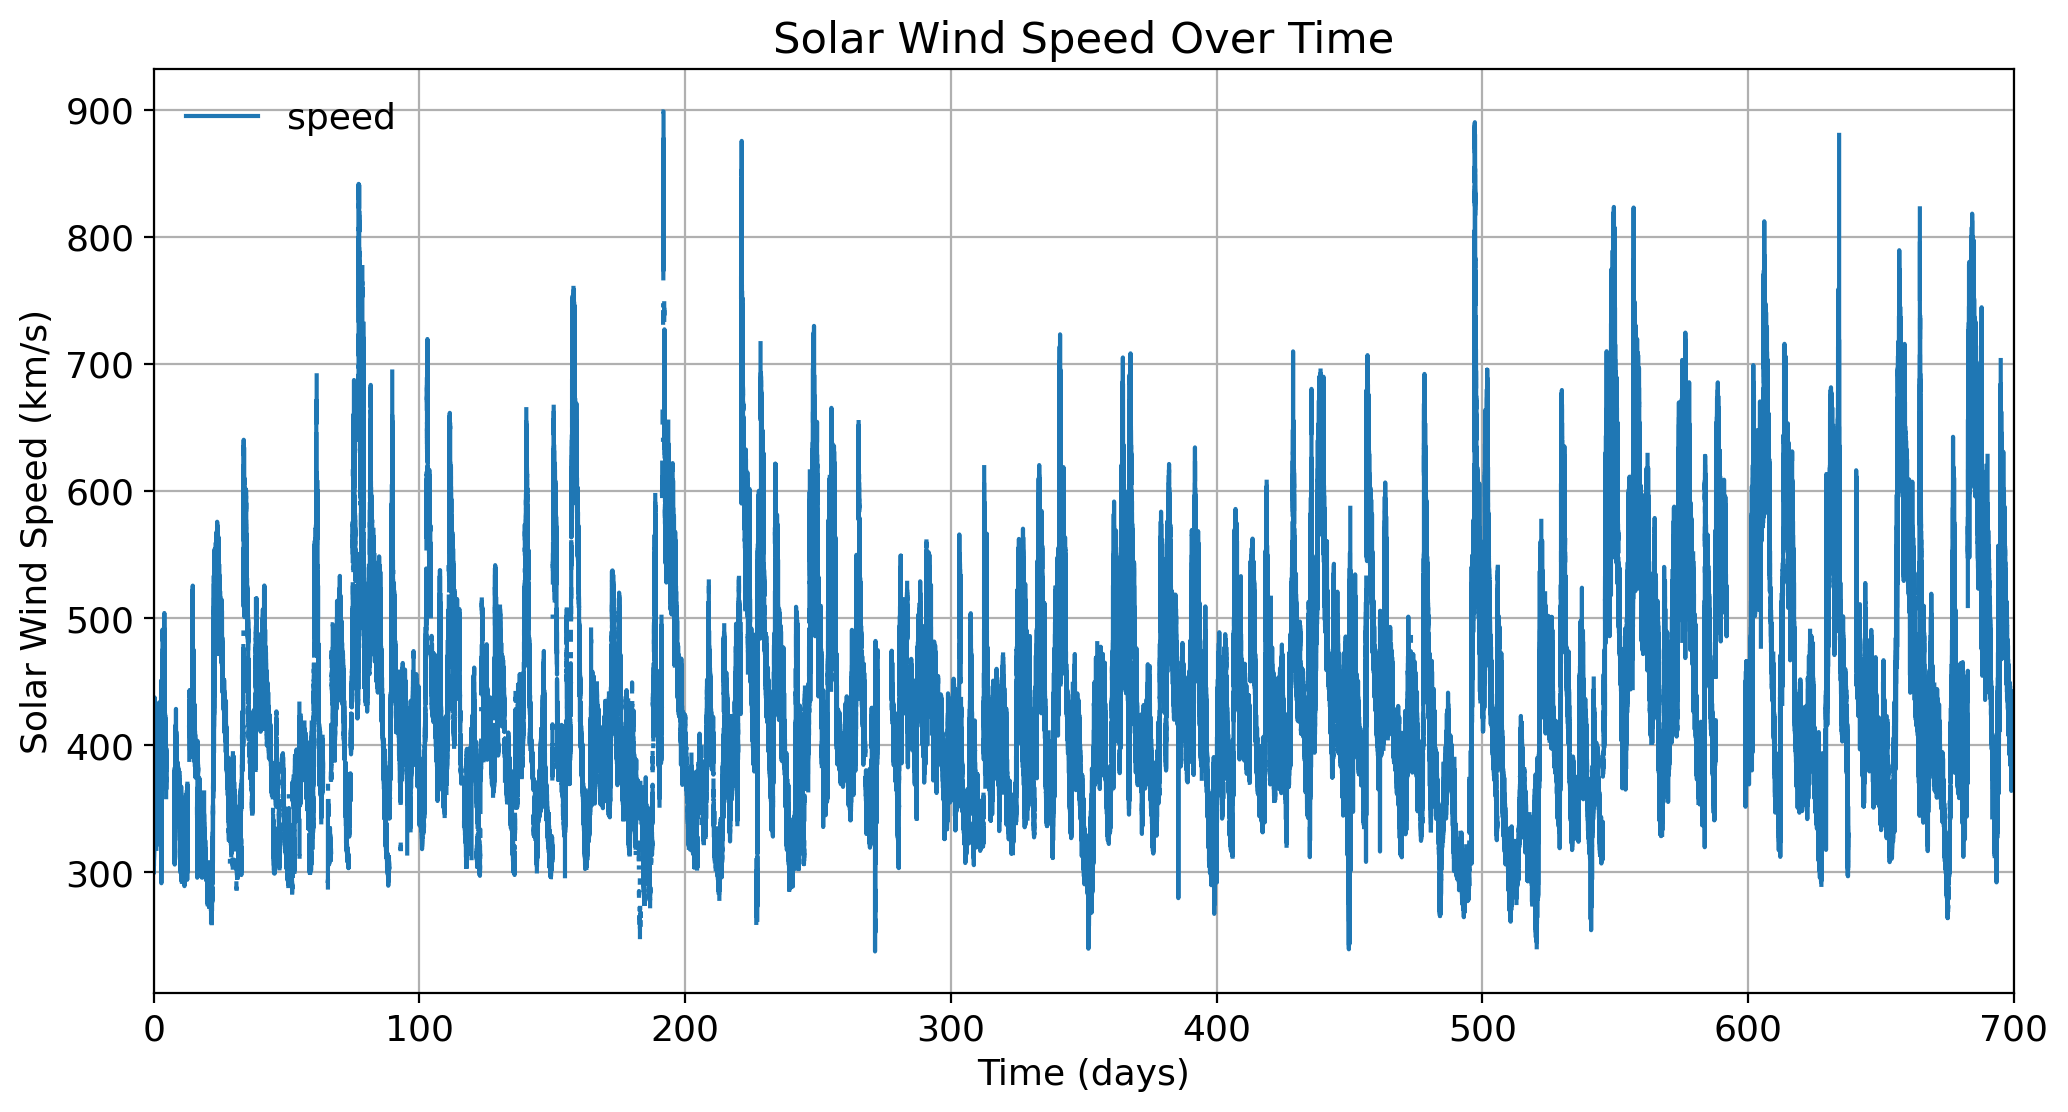

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('training_data.csv')

data['time_days'] = data['timedelta'].apply(lambda x: pd.Timedelta(x).total_seconds() / (3600 * 24))

# Select speed to visualize
feature_to_visualize = 'speed'

plt.figure(figsize=(12, 6))
plt.plot(data['time_days'], data[feature_to_visualize], label=feature_to_visualize)
plt.xlabel('Time (days)')
plt.ylabel('Solar Wind Speed (km/s)')
plt.title('Solar Wind Speed Over Time')
plt.xlim(0, 700)  # Set the x-axis limits to show 700 days
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Define the number of time steps and features
time_steps = 5
num_features = len(features)

# Function to reshape data for LSTM input
def reshape_data(X, y, time_steps):
    num_sequences = len(X) // time_steps
    X_truncated = X[:num_sequences * time_steps]
    y_truncated = y[:num_sequences * time_steps]
    X_reshaped = X_truncated.reshape((num_sequences, time_steps, num_features))
    y_reshaped = y_truncated[time_steps - 1::time_steps]
    print(len(X))
    return X_reshaped, y_reshaped

# Reshape the data
X_train_reshaped, y_train_reshaped = reshape_data(X_train, y_train, time_steps)
X_val_reshaped, y_val_reshaped = reshape_data(X_val, y_val, time_steps)
X_test_reshaped, y_test_reshaped = reshape_data(X_test, y_test, time_steps)

# Initialize the Glorot uniform initializer
initializer = GlorotUniform()

# Define the CNN-LSTM model
model = Sequential([
    Conv1D(filters=52, kernel_size=2, activation='relu', kernel_initializer=initializer, input_shape=(time_steps, num_features)),
    LSTM(60, activation='relu', kernel_initializer=initializer),
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(1, kernel_initializer=initializer)
])

# Compile the model with a suitable learning rate and gradient clipping
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback to stop training if the validation loss isn't improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=50,
    validation_data=(X_val_reshaped, y_val_reshaped),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss = model.evaluate(X_test_reshaped, y_test_reshaped)
print(f'Test Loss: {test_loss}')

# Save the model
model.save('solar_wind_prediction_model.h5')

606370
151593
34624
Epoch 1/50


C:\Users\lenovo\anaconda3\envs\PyOpt\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


3790/3790 [==============================] - 10s 2ms/step - loss: 26153.0801 - val_loss: 8258.1631
Epoch 2/50
3790/3790 [==============================] - 10s 3ms/step - loss: 8175.5640 - val_loss: 8228.9023
Epoch 3/50
3790/3790 [==============================] - 11s 3ms/step - loss: 8119.5957 - val_loss: 8176.9521
Epoch 4/50
3790/3790 [==============================] - 11s 3ms/step - loss: 8086.4214 - val_loss: 8087.4531
Epoch 5/50
3790/3790 [==============================] - 11s 3ms/step - loss: 8050.9307 - val_loss: 8044.0044
Epoch 6/50
3790/3790 [==============================] - 10s 3ms/step - loss: 8004.9697 - val_loss: 8083.9380
Epoch 7/50
3790/3790 [==============================] - 11s 3ms/step - loss: 7911.3945 - val_loss: 7877.0488
Epoch 8/50
3790/3790 [==============================] - 11s 3ms/step - loss: 7777.0581 - val_loss: 7687.5620
Epoch 9/50
3790/3790 [==============================] - 12s 3ms/step - loss: 7498.8003 - val_loss: 7358.0811
Epoch 10/50
3790/3790 [======

C:\Users\lenovo\anaconda3\envs\PyOpt\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


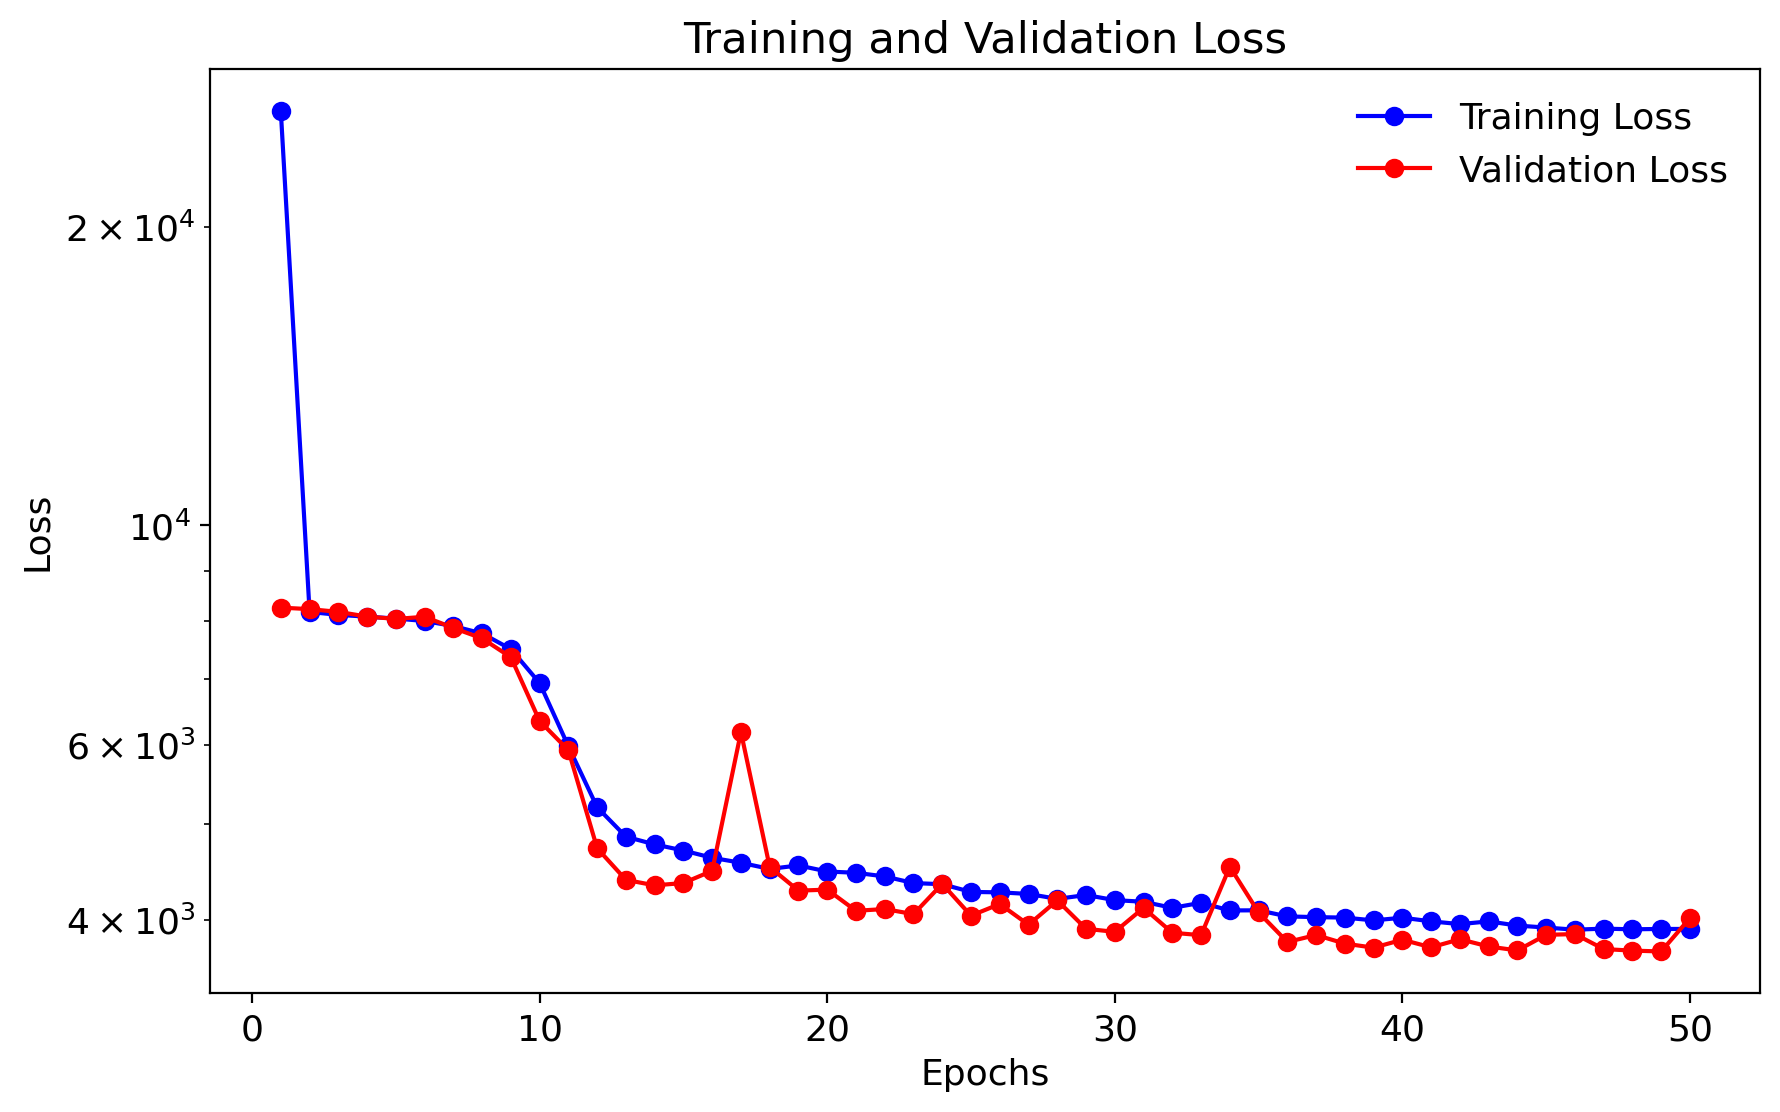

In [6]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.semilogy()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('solar_wind_prediction_model.h5')

# Generate predictions for the test data
# Make sure that X_test_reshaped is correctly preprocessed
predicted_values = model.predict(X_test_reshaped)
print(X_test_reshaped.shape)
print(predicted_values.shape)

217/217 [==============================] - 0s 1ms/step
(6924, 5, 13)
(6924, 1)


Predicted values statistics:
Mean: 432.2897033691406
Median: 403.5986633300781
Variance: 5989.46435546875


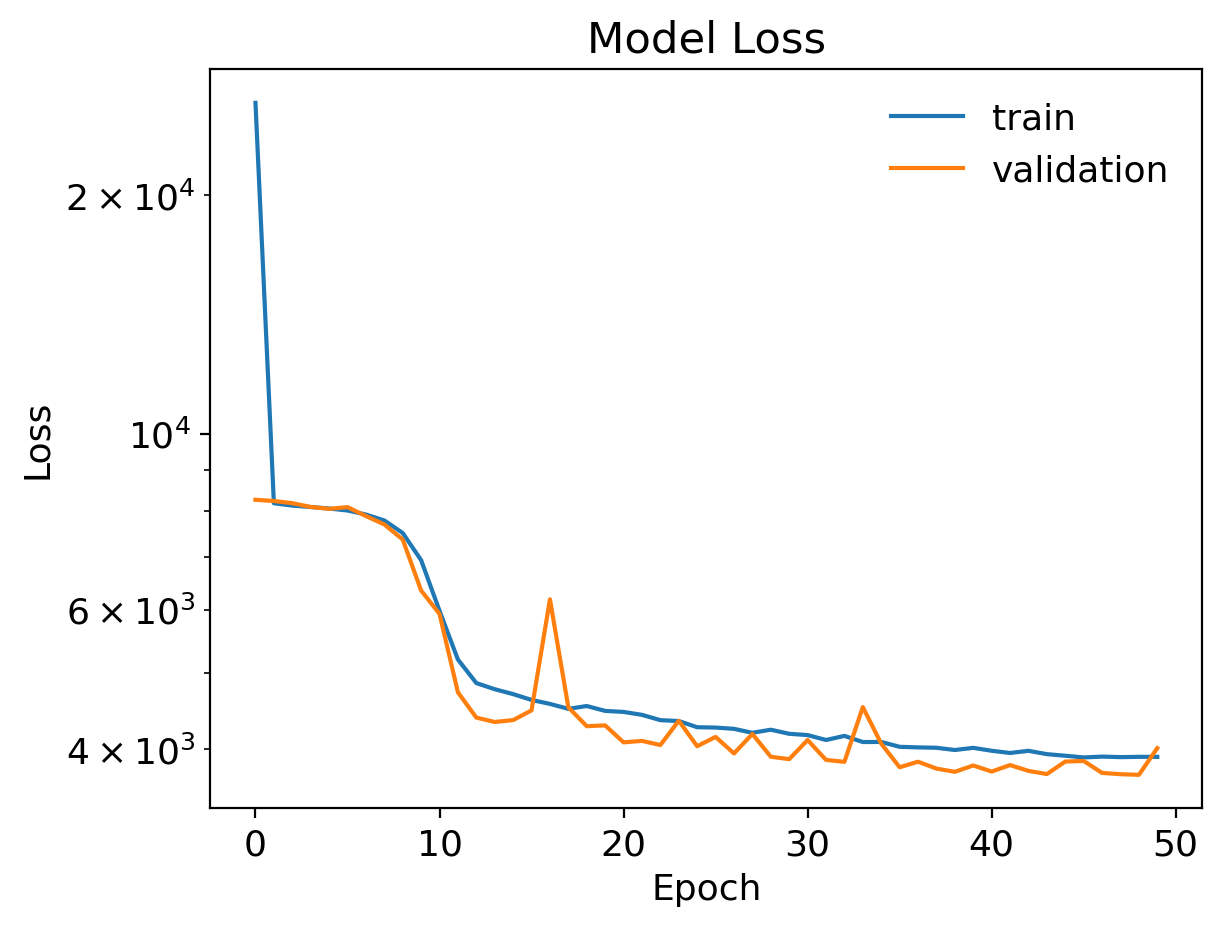

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 52)             1404      
                                                                 
 lstm (LSTM)                 (None, 60)                27120     
                                                                 
 dense (Dense)               (None, 64)                3904      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32493 (126.93 KB)
Trainable params: 32493 (126.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Check the scaling of features:
Feature max values: [[0.77307617 0.91604865 0.82596121 0.98767566 0.99991667 0.77312082
  0.89226076 0.84097467 0.98746

In [8]:
# Assuming predicted_values is a numpy array
print("Predicted values statistics:")
print(f"Mean: {np.mean(predicted_values)}")
print(f"Median: {np.median(predicted_values)}")
print(f"Variance: {np.var(predicted_values)}")
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy()
plt.legend()
plt.show()
model.summary()
# Assuming X_test_reshaped was used for predictions and was scaled properly
print("Check the scaling of features:")
print(f"Feature max values: {np.max(X_test_reshaped, axis=0)}")
print(f"Feature min values: {np.min(X_test_reshaped, axis=0)}")
# Select a small subset of the training data
subset_X_train = X_train_reshaped[:100]  # for example, the first 100 samples
subset_y_train = y_train_reshaped[:100]

# Get predictions on this subset
subset_predictions = model.predict(subset_X_train)

# Check if the subset predictions vary
print("Subset predictions statistics:")
print(f"Mean: {np.mean(subset_predictions)}")
print(f"Variance: {np.var(subset_predictions)}")

aligned: (6924, 1)
predicted: (6924, 1)
(6924,)
(6924,)


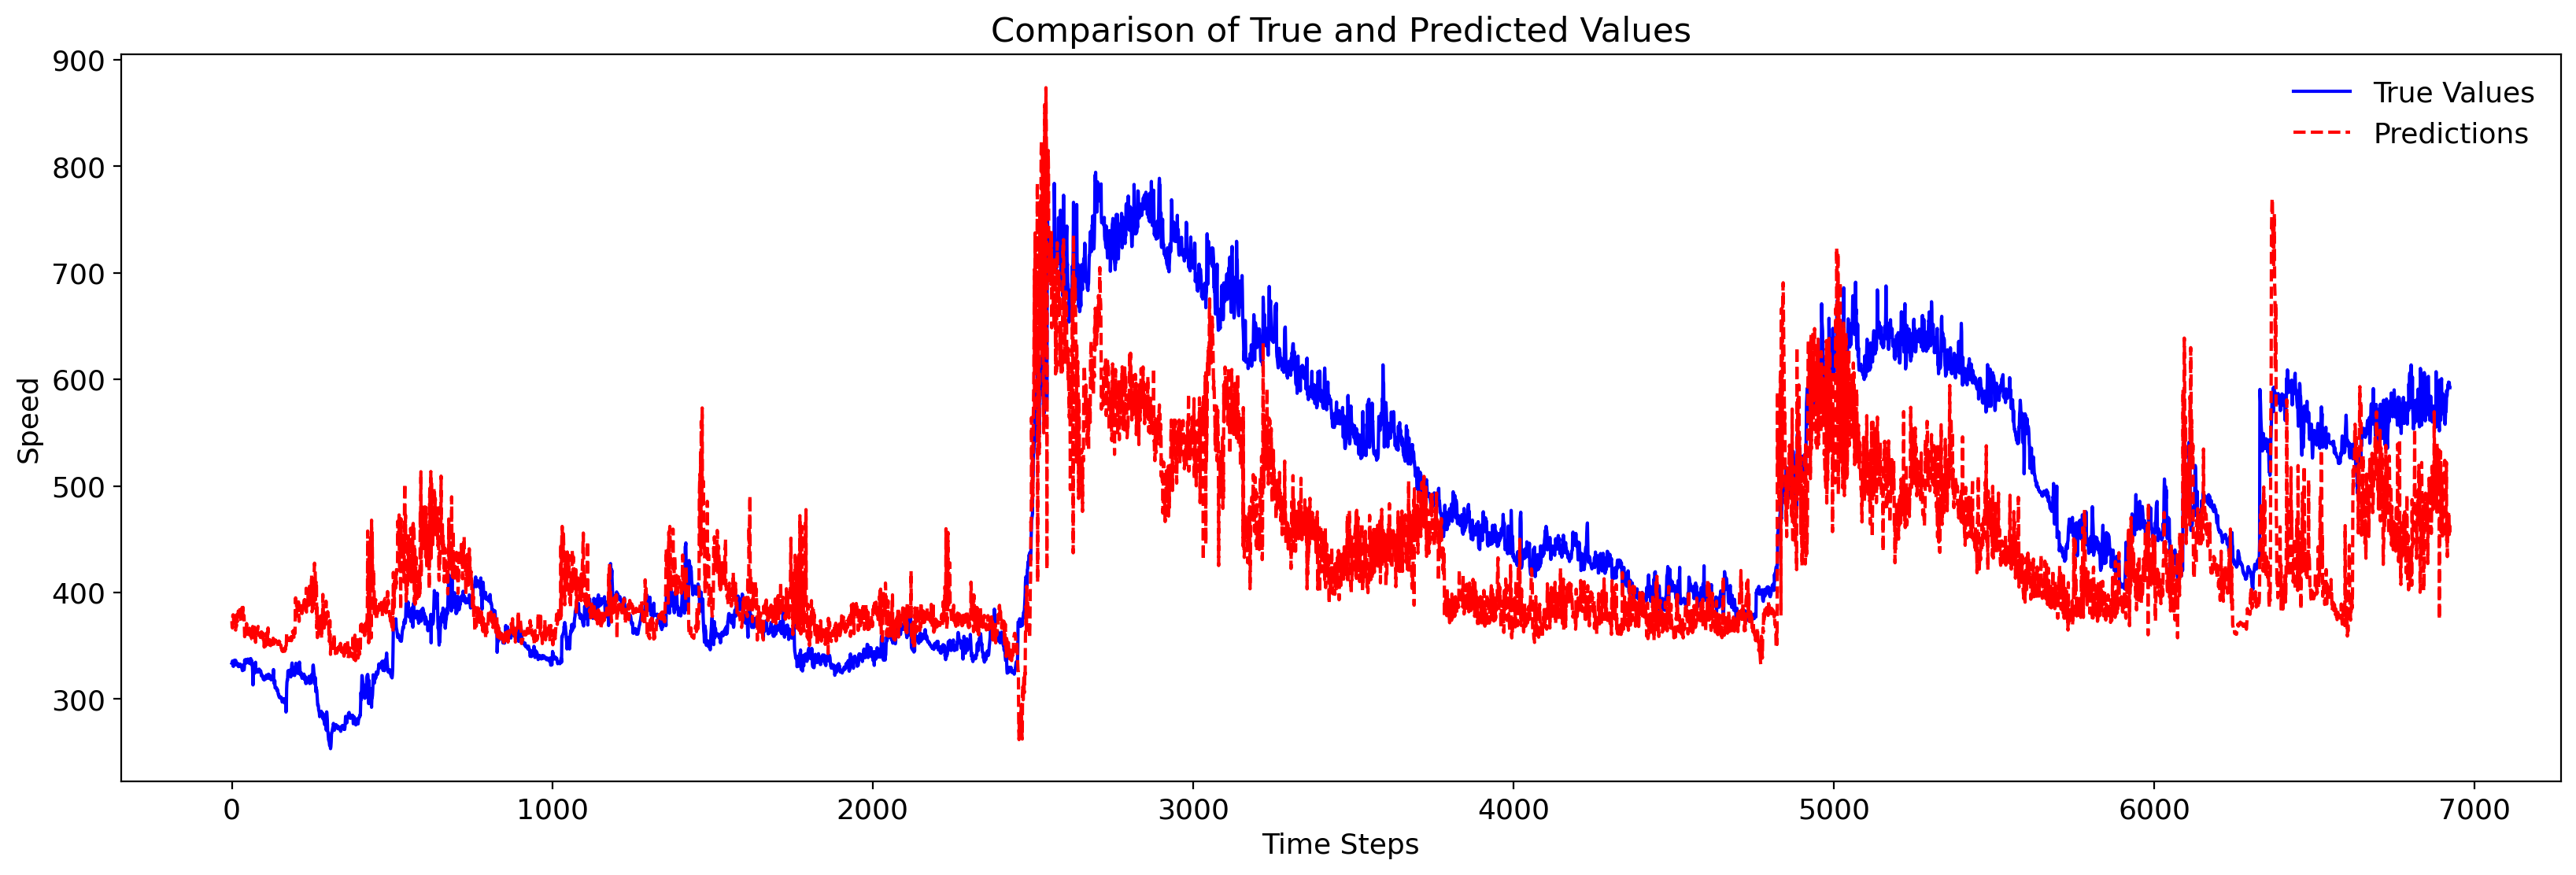

In [9]:
aligned_true_values = y_test[:34620].reshape(6924, 5, 1).mean(axis=1)
print('aligned:',aligned_true_values.shape)
print('predicted:',predicted_values.shape)

# Check the alignment
assert predicted_values.shape[0] == aligned_true_values.shape[0], "The lengths of true and predicted values do not match."

# Flatten the arrays for plotting
predicted_values_flat = predicted_values.flatten()
aligned_true_values_flat = aligned_true_values.flatten()
print(predicted_values_flat.shape)
print(aligned_true_values_flat.shape)

# Create a time axis for plotting, starting from the point where predictions begin
time_axis = np.arange(len(predicted_values_flat))

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(time_axis, aligned_true_values_flat, label='True Values', color='blue')
plt.plot(time_axis, predicted_values_flat, label='Predictions', color='red', linestyle='--')
plt.title('Comparison of True and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Speed')
plt.legend()
plt.show()